In [7]:
import pandas as pd
import numpy as np
# Load the dataset
file_path = 'cerealsbigdata.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure

df.head(), df.info()
#df= df[(df != 0).all(axis=1)]
from sklearn.preprocessing import LabelEncoder

# Convert 'Arrival_Date' to datetime
df['Arrival_Date'] = pd.to_datetime(df['Arrival_Date'], format='%d-%m-%Y')

# Sort data by 'Arrival_Date'
df = df.sort_values(by='Arrival_Date')

# Encode categorical variables ('State' and 'Commodity')
le_state = LabelEncoder()
le_commodity = LabelEncoder()

df['State_encoded'] = le_state.fit_transform(df['State'])
df['Commodity_encoded'] = le_commodity.fit_transform(df['Commodity'])
df = df.drop(['State', 'Commodity'], axis=1)


# Check the processed data
df[['State_encoded',  'Commodity_encoded', 'Arrival_Date']].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70333 entries, 0 to 70332
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         70333 non-null  object 
 1   Commodity     70333 non-null  object 
 2   Arrival_Date  70333 non-null  object 
 3   Min_Price     70333 non-null  float64
 4   Max_Price     70333 non-null  float64
 5   Modal_Price   70333 non-null  float64
dtypes: float64(3), object(3)
memory usage: 3.2+ MB


,State_encoded,Commodity_encoded,Arrival_Date
0,7,0,2002-11-06
1,7,4,2002-11-06
2,7,5,2002-11-06
3,7,1,2002-11-06
4,7,0,2002-11-23


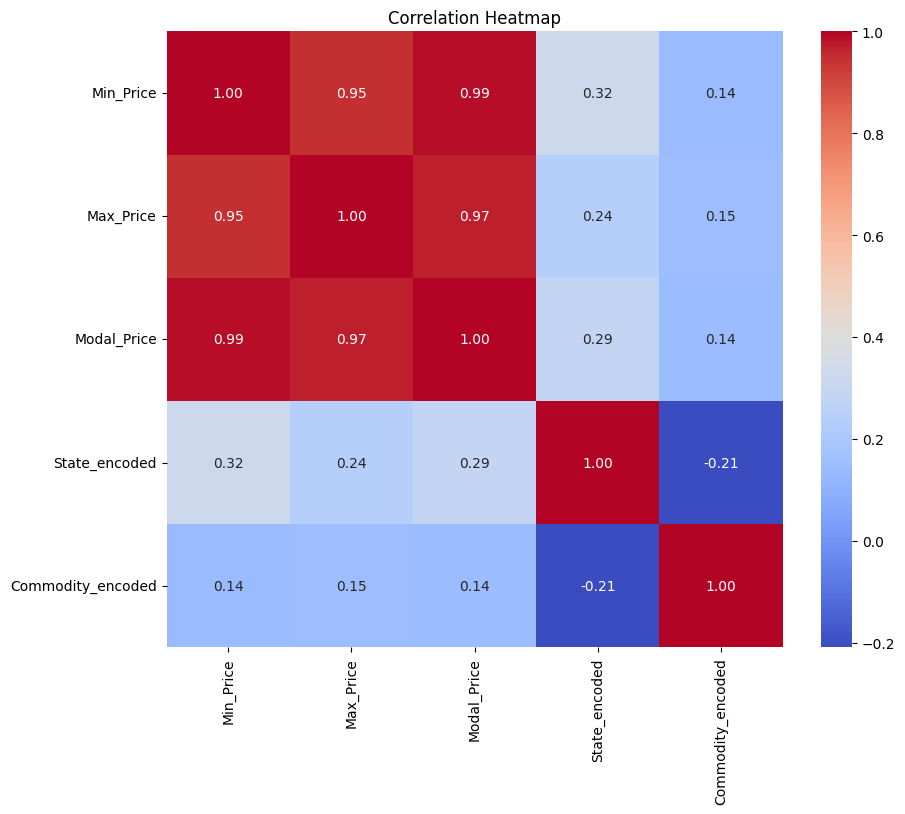

In [8]:
# Correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
correlation_matrix = df[['Min_Price', 'Max_Price', 'Modal_Price', 'State_encoded', 'Commodity_encoded']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

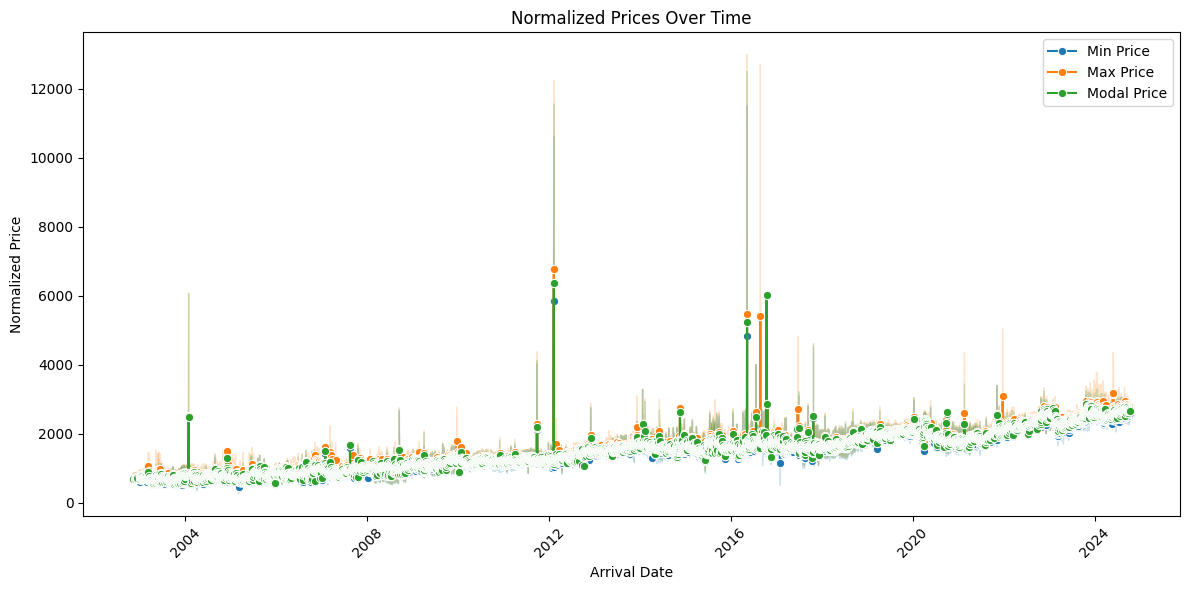

In [9]:
# Plotting normalized prices over Arrival Date
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Arrival_Date', y='Min_Price', label='Min Price', marker='o')
sns.lineplot(data=df, x='Arrival_Date', y='Max_Price', label='Max Price', marker='o')
sns.lineplot(data=df, x='Arrival_Date', y='Modal_Price', label='Modal Price', marker='o')
plt.title('Normalized Prices Over Time')
plt.xlabel('Arrival Date')
plt.ylabel('Normalized Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [2]:



from sklearn.preprocessing import MinMaxScaler

# Normalize price columns
scaler = MinMaxScaler()
df[['Min_Price', 'Max_Price', 'Modal_Price']] = scaler.fit_transform(df[['Min_Price', 'Max_Price', 'Modal_Price']])

# Create a time series dataset for the CNN-LSTM model
def create_time_series_data(data, window_size, target_column):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])  # Input: sequence of window_size time steps
        y.append(data[i+window_size][target_column])  # Output: next price (target)
    return np.array(X), np.array(y)

# Specify window size for time series (e.g., 30 days)
window_size = 30

# Create time series data using normalized prices and encoded features (prices and categorical)
features = df[['Min_Price', 'Max_Price', 'Modal_Price', 'State_encoded', 'Commodity_encoded']].values
target_column = 2  # Modal_Price is the target

X, y = create_time_series_data(features, window_size, target_column)

# Display the shape of the input (X) and output (y)
X.shape, y.shape

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten

# Build the CNN-LSTM model
model = Sequential()

# CNN layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

# LSTM layer
model.add(tf.keras.layers.Reshape((1, -1)))  # Reshape to make it compatible with LSTM
model.add(LSTM(100, activation='relu'))

# Dense layers for output
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Single output for price prediction
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X, y, epochs=30, batch_size=32)


c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 29, 64)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 896)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │       398,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,605 (1.54 MB)

 Trainable params: 404,605 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predict using the model
y_pred = model.predict(X)

# Calculate MSE
mse = mean_squared_error(y, y_pred)

# Calculate MAE
mae = mean_absolute_error(y, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
MSE: 0.0005434642311799747
MAE: 0.01632789768407493
RMSE: 0.023312319300746863


In [10]:
from sklearn.metrics import r2_score

# Calculate R-Squared
r2 = r2_score(y, y_pred)

# Print R-Squared
print(f'R²: {r2}')


R²: 0.7878361840543036


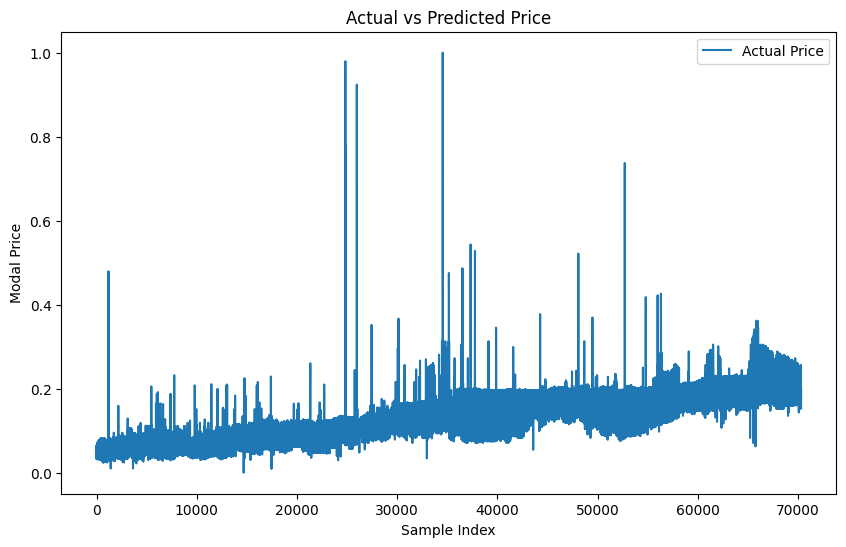

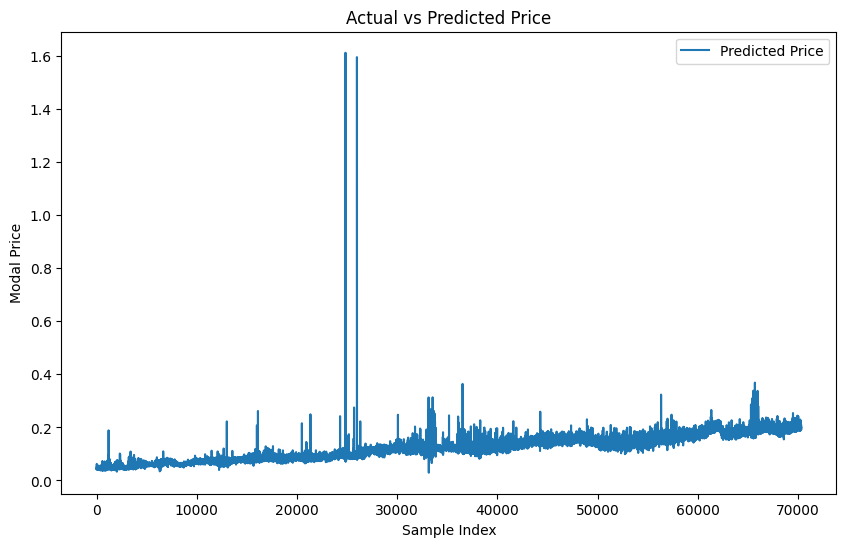

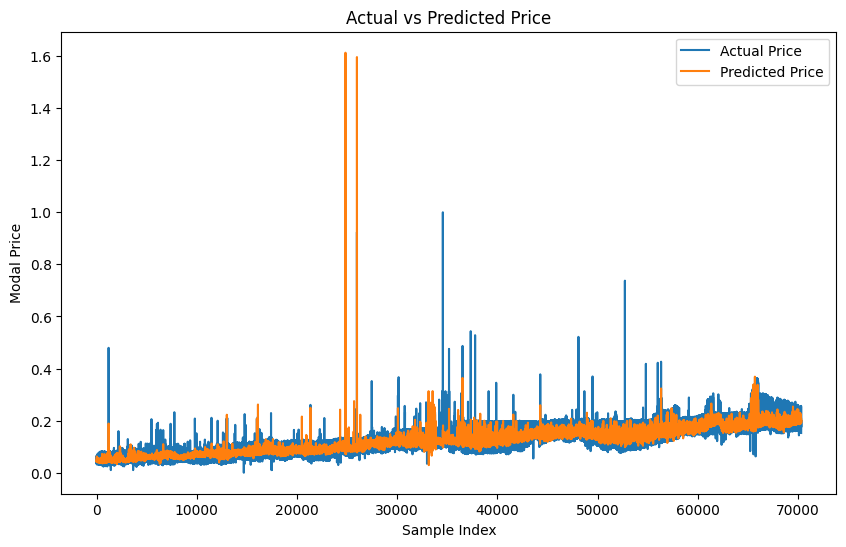

In [11]:
import matplotlib.pyplot as plt

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual Price')
#plt.plot(y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Price')
plt.xlabel('Sample Index')
plt.ylabel('Modal Price')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
#plt.plot(y, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Price')
plt.xlabel('Sample Index')
plt.ylabel('Modal Price')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Price')
plt.xlabel('Sample Index')
plt.ylabel('Modal Price')
plt.legend()
plt.show()

In [12]:
import pandas as pd
import numpy as np


def predict_next_n_days(model, last_n_days_data, state_encoded, commodity_encoded, n_days=10):
    predictions = []
    input_data = np.copy(last_n_days_data)

    for _ in range(n_days):
        # Reshape input data to fit the model (1 sample, window_size timesteps, number of features)
        input_data_reshaped = input_data.reshape((1, input_data.shape[0], input_data.shape[1]))
        print(f"Reshaped input for prediction: {input_data_reshaped.shape}")  # Debug

        # Predict the next day's price
        predicted_price = model.predict(input_data_reshaped)
        predicted_price = predicted_price[0][0]  # Extract scalar value
        print(f"Predicted price: {predicted_price}")  # Debug

        # Store the prediction
        predictions.append(predicted_price)

        # Prepare input for the next step: remove the oldest day and add the new predicted price
        next_input = np.array([0, 0, predicted_price, state_encoded, commodity_encoded])  # Placeholder for Min_Price and Max_Price
        input_data = np.vstack((input_data[1:], next_input))  # Slide the window

    return predictions


def predict_prices_for_all_states_and_commodities(model, file_path, le_state, le_commodity, scaler, n_days=10):
    # Load the data
    new_data = pd.read_csv(file_path)

    # Convert 'Arrival_Date' to datetime and sort by date
    new_data['Arrival_Date'] = pd.to_datetime(new_data['Arrival_Date'], format='%d-%m-%Y')
    new_data = new_data.sort_values(by='Arrival_Date')

    # Encode categorical variables ('State' and 'Commodity')
    new_data['State_encoded'] = le_state.transform(new_data['State'])
    new_data['Commodity_encoded'] = le_commodity.transform(new_data['Commodity'])

    # Normalize price columns using the scaler
    new_data[['Min_Price', 'Max_Price', 'Modal_Price']] = scaler.transform(
        new_data[['Min_Price', 'Max_Price', 'Modal_Price']]
    )

    # Prepare a list to store the results
    results = []

    # Group data by 'State' and 'Commodity'
    grouped_data = new_data.groupby(['State', 'Commodity'])

    # Iterate through each state-commodity group
    for (state, commodity), group in grouped_data:
        # Check if the group has at least 10 days of data
        if len(group) < 30:
            continue  # Skip if insufficient data

        # Get the last 10 days of data
        last_10_days_data = group.tail(30)[
            ['Min_Price', 'Max_Price', 'Modal_Price', 'State_encoded', 'Commodity_encoded']
        ].values

        # Ensure the data has the correct shape (10, 5)
        if last_10_days_data.shape != (30, 5):
            continue  # Skip if the shape is incorrect

        # Encode the state and commodity
        state_encoded = le_state.transform([state])[0]
        commodity_encoded = le_commodity.transform([commodity])[0]
        print(state_encoded,commodity_encoded,last_10_days_data.shape)
        # Predict the next 10 days of prices
        predicted_prices = predict_next_n_days(
            model, last_10_days_data, state_encoded, commodity_encoded, n_days=n_days
        )

        # Generate future dates starting from the last available date + 1
        last_date = group['Arrival_Date'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_days).tolist()

        # Store the predictions
        for date, price in zip(future_dates, predicted_prices):
            results.append([state, commodity, date, price])

    # Convert the results into a DataFrame
    predictions_df = pd.DataFrame(results, columns=['State', 'Commodity', 'Date', 'Predicted_Modal_Price'])

    # Denormalize the predicted modal prices
    predictions_df['Predicted_Modal_Price'] = scaler.inverse_transform(
        np.concatenate([
            np.zeros((len(predictions_df), 2)),  # Placeholders for Min_Price and Max_Price
            predictions_df[['Predicted_Modal_Price']].values  # Modal_Price
        ], axis=1)
    )[:, 2]  # Extract only the denormalized 'Modal_Price' column

    predictions_df['Predicted_Modal_Price'] = predictions_df['Predicted_Modal_Price'].apply(lambda x: f"{x:.2f}")
    
    return predictions_df

# Example usage
predictions_df = predict_prices_for_all_states_and_commodities(
    model, 
    'cereal_test3.csv', 
    le_state, 
    le_commodity, 
    scaler, 
    n_days=10
)

# Save the predictions to a CSV file
predictions_df.to_csv('predicted_prices.csv', index=False)

# Print the predictions
print(predictions_df)


0 4 (30, 5)
Reshaped input for prediction: (1, 30, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted price: 0.12631818652153015
Reshaped input for prediction: (1, 30, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted price: 0.1256369799375534
Reshaped input for prediction: (1, 30, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price: 0.128546804189682
Reshaped input for prediction: (1, 30, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted price: 0.13502824306488037
Reshaped input for prediction: (1, 30, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted price: 0.1345495581626892
Reshaped input for prediction: (1, 30, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted price: 0.12973341345787048
Reshaped input for prediction: (1, 30, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted price: 0.1283838450908661
Reshaped input for prediction: (1, 30, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted price: 0.12737011909484863
Reshaped input for prediction: (1, 30, 5)
1/1 ━━━━━━━━━━━

In [13]:
import pandas as pd

# Assuming `le_state` and `le_commodity` are your LabelEncoders and `df` is your DataFrame

# Create a DataFrame for the encoded values
state_encoded_df = pd.DataFrame({
    'original_value': df['State'],
    'encoded_value': df['State_encoded']
}).drop_duplicates()

commodity_encoded_df = pd.DataFrame({
    'original_value': df['Commodity'],
    'encoded_value': df['Commodity_encoded']
}).drop_duplicates()

# Save to CSV files
state_encoded_df.to_csv('cereal_state_encoded.csv', index=False)
commodity_encoded_df.to_csv('cereal_commodity_encoded.csv', index=False)
model.save('cereal_model.h5')


KeyError: 'State'

In [86]:
scaler.to_csv('scaler.csv', index=False)

AttributeError: 'MinMaxScaler' object has no attribute 'to_csv'